In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
import json

answer = {True:'Yes', False:'No'}

# Reading and Wrangling Data

In [2]:
def calculate_age(x):
    try:
        bdate = pd.to_datetime(x, format='%d.%m.%Y')
        today = pd.to_datetime('today')
        return (today - bdate) // np.timedelta64(1, 'Y')
    except:
        return np.nan

In [3]:
# Reading data
df_friends = pd.read_csv('data.csv')

# Cleaning data
## Dropping "DELETED" accounts
df_friends = df_friends.loc[df_friends.first_name!='DELETED']
## Dropping duplicates
df_friends.drop_duplicates(subset=['source_id','first_name','last_name','sex','bdate','country','city','mobile_phone'],
                           inplace=True)
## Calculating age
df_friends['age'] = df_friends.bdate.apply(calculate_age)
df_friends['age_cut'] = pd.cut(df_friends.age, bins=[0, 18, 25, 30, 40, 50, 60, 70, df_friends.age.max()])

df_friends.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22412 entries, 0 to 25182
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   source_id     22412 non-null  int64   
 1   id            22412 non-null  int64   
 2   first_name    22412 non-null  object  
 3   last_name     22412 non-null  object  
 4   sex           22402 non-null  object  
 5   bdate         14710 non-null  object  
 6   country       16937 non-null  object  
 7   city          14919 non-null  object  
 8   mobile_phone  2018 non-null   object  
 9   age           6874 non-null   float64 
 10  age_cut       6874 non-null   category
dtypes: category(1), float64(1), int64(2), object(7)
memory usage: 1.9+ MB


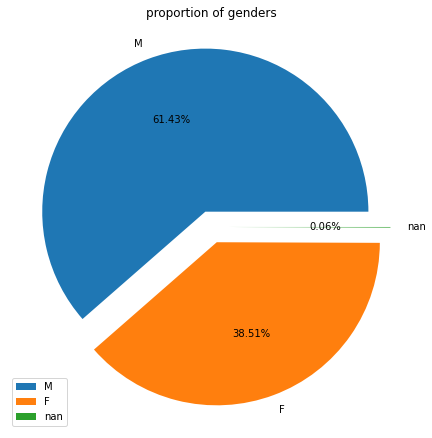

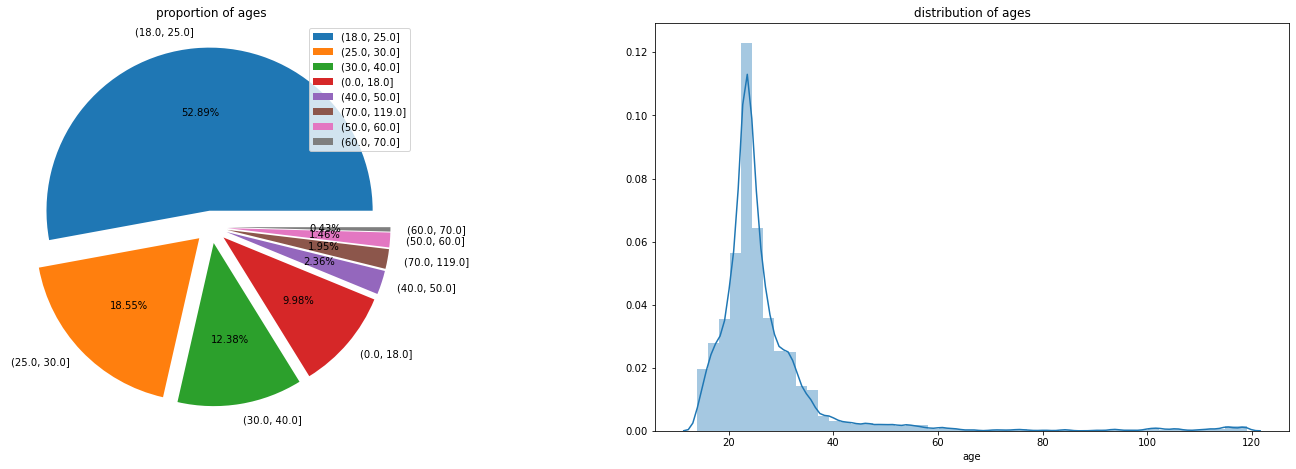

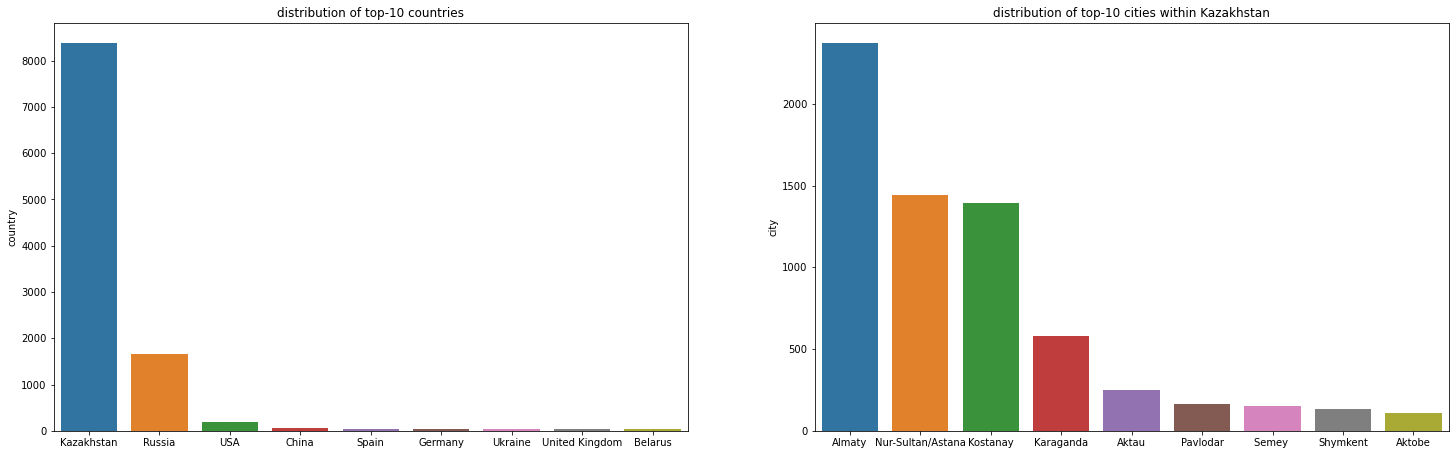

In [4]:
# Creating DataFrame for analysis without duplicates
df_analysis = df_friends.copy()
df_analysis.drop(columns=['source_id'], inplace=True)
df_analysis.drop_duplicates(inplace=True)

# Creating DataFrames for plotting graphs
## Gender
df_genders = df_analysis.sex.value_counts(dropna=False)
## Age
df_age_cuts = df_analysis.age_cut.value_counts(dropna=True)
## Countries
df_countries = df_analysis.country.value_counts(dropna=False).to_frame()
df_countries.sort_values(by='country', ascending=False, inplace=True)
df_countries = df_countries[:10]
## Cities within Kazakhstan
df_kz_cities = df_analysis.loc[df_analysis.country=='Kazakhstan'].city.value_counts(dropna=False).to_frame()
df_kz_cities.sort_values(by='city', ascending=False, inplace=True)
df_kz_cities = df_kz_cities[:10]

# Graph of "proportion of genders"
f, ax = plt.subplots(1, 1, figsize=(7.5, 7.5))
ax.pie(df_genders, labels=df_genders.index, autopct='%1.2f%%', explode=[0.1 for i in range(len(df_genders))])
ax.legend(); ax.set_title('proportion of genders')
plt.show()

# Graphs of "proportion of ages" & "distribution of ages"
f, ax = plt.subplots(1, 2, figsize=(25, 7.5))
## "proportion of ages"
ax[0].pie(df_age_cuts, labels=df_age_cuts.index, autopct='%1.2f%%', explode=[0.1 for i in range(len(df_age_cuts))])
ax[0].legend(); ax[0].set_title('proportion of ages')
## "distribution of ages"
sns.distplot(df_analysis.age, ax=ax[1])
ax[1].set_title('distribution of ages')
plt.show()

# Graphs of "distribution of top-10 countries" & "distribution of top-10 cities within Kazakhstan"
f, ax = plt.subplots(1, 2, figsize=(25, 7.5))
## "distribution of top-10 countries"
sns.barplot(x=df_countries.index, y='country', data=df_countries, ax=ax[0])
ax[0].set_title('distribution of top-10 countries')
## "distribution of top-10 cities within Kazakhstan"
sns.barplot(x=df_kz_cities.index, y='city', data=df_kz_cities, ax=ax[1])
ax[1].set_title('distribution of top-10 cities within Kazakhstan')
plt.show()

# Social Graph

### Graph that includes me

In [5]:
# Creating a Social Graph (including me)
G1 = nx.Graph(name='including me')

# Nodes
df_nodes = df_analysis[['id','first_name','last_name','sex']].copy()
df_nodes.set_index('id', inplace=True)
dict_nodes = df_nodes.to_dict(orient='index')
list_nodes = [(key, dict_nodes[key]) for key in dict_nodes]
# Adding nodes into the graph
G1.add_nodes_from(list_nodes)

# Edges
edges = df_friends[['source_id','id']].to_records(index=False)
## Adding edges into the graph
G1.add_edges_from(edges)

# Basic info
print(nx.info(G1))

Name: including me
Type: Graph
Number of nodes: 14804
Number of edges: 21720
Average degree:   2.9343


In [6]:
# Connectivity
print(f'1. Is G connected? {answer[nx.is_connected(G1)]}.')
print(f'2. Average clustering: {nx.average_clustering(G1)}.')
print(f'3. Transitivity: {nx.transitivity(G1)}.')

1. Is G connected? Yes.
2. Average clustering: 0.10102440550777647.
3. Transitivity: 0.018489584701138498.


In [7]:
# Distance measures
#print(f'1. Average shortest path length (G1): {nx.average_shortest_path_length(G1)}.')
#print(f'2. Diameter (G1): {nx.diameter(G1)}'.)
#print(f'3. Radius (G1): {nx.radius(G1)}.')

**Note**: The cell above can not run because of **high time-complexity**.

In [8]:
# Network centralization
df_nodes['clustering'] = pd.Series(nx.clustering(G1))
df_nodes['degree'] = pd.Series(dict(G1.degree))
df_nodes['degree_centrality'] = pd.Series(nx.degree_centrality(G1))

In [9]:
df_nodes.sort_values(by=['degree', 'clustering'], ascending=True).head(50)

,first_name,last_name,sex,clustering,degree,degree_centrality
id,,,,,,
5605529,Aydana,Aytuarova,F,0.0,1,0.000068
5733553,Nikola,Mirkovich,M,0.0,1,0.000068
6204155,Ayganym,Baygazanova,F,0.0,1,0.000068
8509663,Ardak,Shalkarbayuli,M,0.0,1,0.000068
9004794,Bakhtiyar,Jangeldinov,M,0.0,1,0.000068
10436926,Muslim,Dzholdaspaev,M,0.0,1,0.000068
11331946,Daniel,Khassanov,M,0.0,1,0.000068
11519479,Nazgul,Abdinurova,F,0.0,1,0.000068
12541644,Azamat,Almukhametov,M,0.0,1,0.000068


**Note**: Some **centrality measures** (*closeness* & *betweenness*) can not run because of **high time-complexity**.

### Graph that excludes me

In [10]:
# Creating a Social Graph (excluding me)
G2 = nx.Graph(name='excluding me')

# Nodes
df_nodes = df_analysis[['id','first_name','last_name','sex']].copy()
df_nodes.set_index('id', inplace=True)
dict_nodes = df_nodes.to_dict(orient='index')
list_nodes = [(key, dict_nodes[key]) for key in dict_nodes]
# Adding nodes into the graph
G2.add_nodes_from(list_nodes)

# Edges
edges = df_friends[['source_id','id']].to_records(index=False)
## Adding edges into the graph
G2.add_edges_from(edges)

# Removing my node from the graph
## Reading json file
json_file = json.load(open('params.json'))
node = int(json_file['source_id'])
## Removing node
G2.remove_node(node)

# Basic info
print(nx.info(G2))

Name: excluding me
Type: Graph
Number of nodes: 14803
Number of edges: 21607
Average degree:   2.9193


In [11]:
# Connectivity
print(f'1. Is G connected? {answer[nx.is_connected(G2)]}.')
print(f'2. Amount of connected components: {nx.number_connected_components(G2)}.')
print(f'3. Average clustering: {nx.average_clustering(G2)}.')
print(f'4. Transitivity: {nx.transitivity(G2)}.')

1. Is G connected? No.
2. Amount of connected components: 3.
3. Average clustering: 0.10101746053729264.
4. Transitivity: 0.018004658973199215.


**Note**: As $G_2$ is not a connected graph, *distance measures* are not applicable to this graph.

# Challenges:
- A huge network requires a computer with high capabilities (to estimate distance measures, centralities, and to draw network).
- Data consists of fake accounts and accounts with strange age, mobile phone. Very probably, the data of most social networks are dirty, and cleaning this data is a big challenge.